# Image-to-Image Semantic Matching with AutoMM

In [ ]:
pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other require

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.1+cu121
    Uninstalling torchaudio-2.4.1+cu121:
      Successfully uninstalled torchaudio-2.4.1+cu121


In [ ]:
import os
import pandas as pd
import warnings
from IPython.display import Image, display
warnings.filterwarnings('ignore')

In [ ]:
download_dir = './ag_automm_tutorial_img2img'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/Stanford_Online_Products.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 3.08G/3.08G [04:00<00:00, 12.8MiB/s]


## load the annotations into dataframes.

In [ ]:
dataset_path = os.path.join(download_dir, 'Stanford_Online_Products')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col_1 = "Image1"
image_col_2 = "Image2"
label_col = "Label"
match_label = 1

## Expand the image paths since the original paths are relative.

In [ ]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

for image_col in [image_col_1, image_col_2]:
    train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

In [ ]:
train_data.head()

,Image1,Image2,Label
0,/content/ag_automm_tutorial_img2img/Stanford_O...,/content/ag_automm_tutorial_img2img/Stanford_O...,0
1,/content/ag_automm_tutorial_img2img/Stanford_O...,/content/ag_automm_tutorial_img2img/Stanford_O...,1
2,/content/ag_automm_tutorial_img2img/Stanford_O...,/content/ag_automm_tutorial_img2img/Stanford_O...,0
3,/content/ag_automm_tutorial_img2img/Stanford_O...,/content/ag_automm_tutorial_img2img/Stanford_O...,1
4,/content/ag_automm_tutorial_img2img/Stanford_O...,/content/ag_automm_tutorial_img2img/Stanford_O...,1


## Let's visualize a matching image pair.

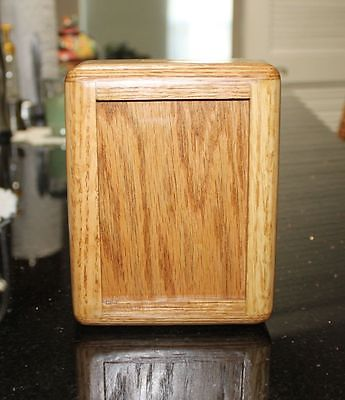

In [ ]:
pil_img = Image(filename=train_data[image_col_1][5])
display(pil_img)

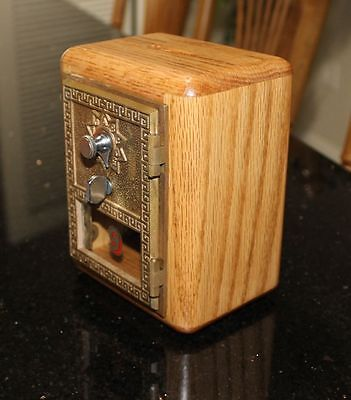

In [ ]:
pil_img = Image(filename=train_data[image_col_2][5])
display(pil_img)

## Here are two images that do not match.

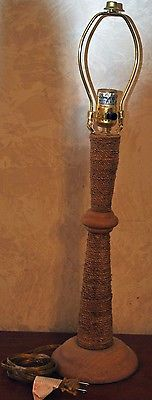

In [ ]:
pil_img = Image(filename=train_data[image_col_1][0])
display(pil_img)

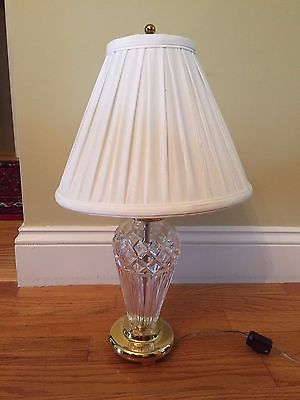

In [ ]:
pil_img = Image(filename=train_data[image_col_2][0])
display(pil_img)

## Train The Model

In [ ]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(
        problem_type="image_similarity",
        query=image_col_1, # the column name of the first image
        response=image_col_2, # the column name of the second image
        label=label_col, # the label column name
        match_label=match_label, # the label indicating that query and response have the same semantic meanings.
        eval_metric='auc', # the evaluation metric
    )

# Fit the model
predictor.fit(
    train_data=train_data,
    time_limit=180,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240923_040823"
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Pytorch Version:    2.3.1+cu121
CUDA Version:       12.1
Memory Avail:       80.36 GB / 83.48 GB (96.3%)
Disk Space Avail:   187.64 GB / 235.68 GB (79.6%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have instal

model.safetensors:   0%|          | 0.00/395M [00:00<?, ?B/s]

GPU Count: 1
GPU Count to be Used: 1
GPU 0 Name: NVIDIA A100-SXM4-40GB
GPU 0 Memory: 0.44GB/40.0GB (Used/Total)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type                            | Params | Mode 
------------------------------------------------------------------------------
0 | query_model       | TimmAutoModelForImagePrediction | 93.3 M | train
1 | response_model    | TimmAutoModelForImagePrediction

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 15: 'val_roc_auc' reached 0.82830 (best 0.82830), saving model to '/content/AutogluonModels/ag-20240923_040823/epoch=0-step=15.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 32: 'val_roc_auc' reached 0.92451 (best 0.92451), saving model to '/content/AutogluonModels/ag-20240923_040823/epoch=0-step=32.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 47: 'val_roc_auc' reached 0.94139 (best 0.94139), saving model to '/content/AutogluonModels/ag-20240923_040823/epoch=1-step=47.ckpt' as top 3
INFO: Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 52: 'val_roc_auc' reached 0.94638 (best 0.94638), saving model to '/content/AutogluonModels/ag-20240923_040823/epoch=1-step=52.ckpt' as top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20240923_040823")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




## Evaluate on Test Dataset

In [ ]:
score = predictor.evaluate(test_data)
print("evaluation score: ", score)

Predicting: |          | 0/? [00:00<?, ?it/s]

evaluation score:  {'roc_auc': 0.9525178631124775}


In [ ]:
pred = predictor.predict(test_data.head(3))
print(pred)

Predicting: |          | 0/? [00:00<?, ?it/s]

0    1
1    1
2    1
Name: Label, dtype: int64


In [ ]:
proba = predictor.predict_proba(test_data.head(3))
print(proba)

Predicting: |          | 0/? [00:00<?, ?it/s]

          0         1
0  0.341968  0.658032
1  0.036311  0.963689
2  0.066305  0.933695


In [ ]:
embeddings_1 = predictor.extract_embedding({image_col_1: test_data[image_col_1][:5].tolist()})
print(embeddings_1.shape)
embeddings_2 = predictor.extract_embedding({image_col_2: test_data[image_col_2][:5].tolist()})
print(embeddings_2.shape)

Predicting: |          | 0/? [00:00<?, ?it/s]

(5, 768)


Predicting: |          | 0/? [00:00<?, ?it/s]

(5, 768)
